In [1]:
import gym
import Lorenz_envs
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import warnings

from IPython import display
from torch.distributions import MultivariateNormal
from torch.optim import Adam
from torch.nn import Linear, Module, MSELoss, ReLU, Sequential

warnings.filterwarnings("ignore")

/home/phu/anaconda3/envs/cmpe258/lib/python3.9/site-packages/gym/envs/registration.py:216: UserWarning: WARN: Overriding environment ALE/Tetris-v5
  logger.warn("Overriding environment {}".format(id))
/home/phu/anaconda3/envs/cmpe258/lib/python3.9/site-packages/gym/envs/registration.py:216: UserWarning: WARN: Overriding environment ALE/Tetris-ram-v5
  logger.warn("Overriding environment {}".format(id))
/home/phu/anaconda3/envs/cmpe258/lib/python3.9/site-packages/gym/envs/registration.py:216: UserWarning: WARN: Overriding environment ALE/Pitfall2-v5
  logger.warn("Overriding environment {}".format(id))
/home/phu/anaconda3/envs/cmpe258/lib/python3.9/site-packages/gym/envs/registration.py:216: UserWarning: WARN: Overriding environment ALE/Pitfall2-ram-v5
  logger.warn("Overriding environment {}".format(id))
/home/phu/anaconda3/envs/cmpe258/lib/python3.9/site-packages/gym/envs/registration.py:216: UserWarning: WARN: Overriding environment ALE/LaserGates-v5
  logger.warn("Overriding environ

## Feed-Forward Network

In [2]:
class PolicyNetwork(Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = Sequential(
            Linear(input_dim, 64),
            ReLU(),
            Linear(64, 64),
            ReLU(),
            Linear(64, output_dim)
        )
    
    def forward(self, observation):
        if isinstance(observation, np.ndarray):
            observation = torch.tensor(observation, dtype=torch.float)
        return self.model(observation)

## Reward Functions

In [3]:
class RewardStrategy:
    def __init__(self, gamma, gae_lambda):
        self.gamma = gamma
        self.gae_lambda = gae_lambda

class RewardsToGo(RewardStrategy):
    def __init__(self, gamma, gae_lambda):
        super().__init__(gamma, gae_lambda)

    def compute_advantages(self, rewards, values, masks):
        batch_rtgs = []
        for episode_rewards in reversed(rewards):
            discounted_reward = 0
            for reward in reversed(episode_rewards):
                discounted_reward = reward + discounted_reward * self.gamma
                batch_rtgs.insert(0, discounted_reward)
        
        batch_rtgs = torch.tensor(batch_rtgs, dtype=torch.float)
        adv = batch_rtgs - values
        return batch_rtgs, adv

class GeneralizedAdvantage(RewardStrategy):
    def __init__(self, gamma, gae_lambda):
        super().__init__(gamma, gae_lambda)
        self.coeff = gamma * gae_lambda

    def compute_advantages(self, rewards, values, masks):
        flat_rewards = torch.flatten(rewards)
        batch_size = len(flat_rewards)
        advantage = np.zeros(batch_size + 1)
        advantage[batch_size - 1] = flat_rewards[batch_size - 1] - values[batch_size - 1]

        for i in reversed(range(batch_size - 1)):
            delta = flat_rewards[i] + (masks[i] * self.gamma * values[i + 1]) - values[i]
            advantage[i] = delta + (masks[i] * self.coeff * advantage[i + 1])
        
        advantage = torch.tensor(advantage[:batch_size])
        batch_returns = advantage + np.squeeze(values)
        batch_returns = torch.tensor(batch_returns, dtype=torch.float)
        return batch_returns, advantage

## Objective Functions

In [4]:
class Objective:
    def __init__(self, epsilon):
        self.epsilon = epsilon

class SurrogateObjectiveClip(Objective):
    def __init__(self, epsilon):
        super().__init__(epsilon)

    def get_loss(self, ratios, advantage):
        surrogate_loss = ratios * advantage
        clipped_surrogate_loss = torch.clamp(ratios, 1 - self.epsilon, 1 + self.epsilon) * advantage

        return (-torch.min(surrogate_loss, clipped_surrogate_loss)).mean()

class SurrogateObjectiveNoClip(Objective):
    def __init__(self, epsilon):
        super().__init__(epsilon)

    def get_loss(self, ratios, advantage):
        surrogate_loss = ratios * advantage

        return (-torch.min(surrogate_loss)).mean()

## PPO

In [5]:
class PPO:
    def __init__(self, env, policy_class, reward_class, objective_class, seed: int = 260):
        # Initialize hyperparameters
        self.timesteps_per_batch = 5000
        self.max_timesteps_per_episode = 1000
        self.updates_per_iteration = 5
        self.lr = 3e-4
        self.gamma = 0.99
        self.gae_lambda = 0.95
        self.epsilon = 0.2
        self.critic_discount = 0.5
        self.seed = seed
        torch.manual_seed(self.seed)

        # Initialize other parameters
        self.render = True
        self.render_interval = 10

        # Set environment params
        self.env = env
        self.observation_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]

        # Initialize networks
        self.actor = policy_class(self.observation_dim, self.action_dim)
        self.critic = policy_class(self.observation_dim, 1)

        # Initialize advantage and objective functions
        self.reward_strategy = reward_class(self.gamma, self.gae_lambda)
        self.objective = objective_class(self.epsilon)

        # Initialize optimizers
        self.actor_optimizer = Adam(self.actor.parameters(), lr=self.lr)
        self.critic_optimizer = Adam(self.critic.parameters(), lr=self.lr)

        # Initialize covariance matrix
        self.cov_matrix = torch.diag(torch.full(size=(self.action_dim,), fill_value=0.5))

        # Initialize logger
        self.logger = {
            "delta_time": time.time_ns(),
            "current_timesteps": 0,
            "current_iterations": 0,
            "batch_lens": [],
            "batch_rewards": [],
            "actor_losses": [],
            "total_losses": [],
        }

        # Initialize results
        self.results = {
            "iteration_count": [],
            "accumulated_rewards": [],
            "total_losses": []
        }
    
    def train(self, max_timesteps):
        current_timesteps, current_iterations = 0, 0
        while current_timesteps < max_timesteps:
            # Run batch simulations (set of trajectories from running policy in the environment)
            batch_obs, batch_acts, batch_log_probs, batch_rewards, batch_lens, batch_masks = self.batch_simulation()

            # Increment timesteps and iterations
            current_timesteps += np.sum(batch_lens)
            current_iterations += 1
            self.logger["current_timesteps"] = current_timesteps
            self.logger["current_iterations"] = current_iterations

            # Calculate returns and advantages
            values, _ = self.evaluate(batch_obs, batch_acts)
            batch_returns, adv = self.reward_strategy.compute_advantages(batch_rewards, values.detach(), batch_masks)

            # Normalize advantages
            adv = (adv - adv.mean()) / (adv.std() + 1e-10)

            # Update the networks
            for _ in range(self.updates_per_iteration):
                V_phi, log_probs = self.evaluate(batch_obs, batch_acts)
                policy_ratios = torch.exp(log_probs - batch_log_probs)

                # Calculate actor and critic losses
                actor_loss  = self.objective.get_loss(policy_ratios, adv)
                critic_loss = MSELoss()(V_phi, batch_returns)
                
                # Calculate gradients and perform backward propagation for actor/critic networks
                self.actor_optimizer.zero_grad()
                actor_loss.backward(retain_graph=True)
                self.actor_optimizer.step()
                self.critic_optimizer.zero_grad()
                critic_loss.backward()
                self.critic_optimizer.step()

                self.logger["actor_losses"].append(actor_loss.detach())
                self.logger["total_losses"].append(actor_loss.detach() + self.critic_discount * critic_loss.detach())

            self._log_summary()

    def batch_simulation(self):
        batch_obs = []
        batch_acts = []
        batch_log_probs = []
        batch_rewards = []
        batch_lens = []
        batch_masks = []

        current_iteration = self.logger["current_iterations"]
        t = 0
        while t < self.timesteps_per_batch:
            episode_rewards = []
            observation = self.env.reset()
            is_done = False
            episode_t = 0

            # Run an episode
            for episode_t in range(self.max_timesteps_per_episode):
                if self.render and len(batch_lens) == 0 and (current_iteration % self.render_interval == 0):
                    self.env.render()
                
                # Calculate an action and make that action in the environment
                batch_obs.append(observation)
                action, log_prob = self.get_action(observation)
                observation, reward, is_done, _ = self.env.step(action)
                print('ob:', observation)
                print('reward:', reward)
                print('step: ', episode_t)
                print('done: ', is_done)
                # Track rewards, actions, and log probs
                episode_rewards.append(reward)
                batch_acts.append(action)
                batch_log_probs.append(log_prob)
                batch_masks.append(0 if is_done else 1)

                t += 1
                if is_done:
                    break

            batch_lens.append(episode_t + 1)
            batch_rewards.append(episode_rewards)
        
        # Cast everything we need to a tensor
        batch_obs = torch.tensor(batch_obs, dtype=torch.float)
        batch_acts = torch.tensor(batch_acts, dtype=torch.float)
        batch_log_probs = torch.tensor(batch_log_probs, dtype=torch.float)
        batch_rewards = torch.tensor(batch_rewards, dtype=torch.float)
        batch_masks = torch.tensor(batch_masks, dtype=torch.float)

        self.logger["batch_rewards"] = batch_rewards
        self.logger["batch_lens"] = batch_lens

        return batch_obs, batch_acts, batch_log_probs, batch_rewards, batch_lens, batch_masks

    def evaluate(self, observations, actions):
        # Calculate the values of each observation
        values = self.critic(observations).squeeze()

        # Calculate the log probabilities of each action
        mean = self.actor(observations)
        distribution = MultivariateNormal(mean, self.cov_matrix)
        log_probs = distribution.log_prob(actions)

        return values, log_probs
    
    def get_action(self, observation):
        # Sample the distribution for an action
        mean = self.actor(observation)
        distribution = MultivariateNormal(mean, self.cov_matrix)
        action = distribution.sample()

        # Calculate the log probability for the sampled action
        log_prob = distribution.log_prob(action)

        return action.detach().numpy(), log_prob.detach()

    def get_results(self):
        return self.results

    def _log_summary(self):
        delta_t = self.logger["delta_time"]
        self.logger["delta_time"] = time.time_ns()
        delta_t = str(round((self.logger["delta_time"] - delta_t) / 1e9, 2))

        # Calculate everything we want to log
        current_timestep = self.logger["current_timesteps"]
        current_iteration = self.logger["current_iterations"]
        avg_ep_lens = np.mean(self.logger["batch_lens"])
        avg_ep_rewards = np.mean([np.sum(np.array(ep_rewards)) for ep_rewards in self.logger["batch_rewards"]])
        avg_actor_loss = np.mean([losses.float().mean() for losses in self.logger["actor_losses"]])
        avg_total_loss = np.mean([losses.float().mean() for losses in self.logger["total_losses"]])

        # Print logging statements
        display.clear_output()
        print()
        print(f"-------------------- Iteration #{current_iteration} --------------------")
        print(f"Average Episodic Length: {avg_ep_lens:.2f}")
        print(f"Average Episodic Return: {avg_ep_rewards:.2f}")
        print(f"Average Actor Loss: {avg_actor_loss:.5f}")
        print(f"Average Total Loss: {avg_total_loss:.5f}")
        print(f"Current Timestep: {current_timestep}")
        print(f"Iteration took: {delta_t} secs")
        print(f"------------------------------------------------------")
        print()

        # Save data for displaying graphs
        self.results["iteration_count"].append(current_iteration)
        self.results["accumulated_rewards"].append(avg_ep_rewards)
        self.results["total_losses"].append(avg_total_loss)

        # Reset batch-specific logging data
        self.logger["batch_lens"] = []
        self.logger["batch_rewards"] = []
        self.logger["actor_losses"] = []
        self.logger["total_losses"] = []

## Display Function

In [6]:
def display_results(model_results, settings_str):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))
    fig.suptitle(settings_str)

    # Display rewards graph
    ax1.plot(model_results["iteration_count"], model_results["accumulated_rewards"])
    ax1.set_title("Rewards")
    ax1.set_xlabel("Iteration Count")
    ax1.set_ylabel("Average Episodic Reward")

    # Display total losses graph
    ax2.plot(model_results["iteration_count"], model_results["total_losses"])
    ax2.set_title("Losses")
    ax2.set_xlabel("Iteration Count")
    ax2.set_ylabel("Average Total Loss")

    plt.show()

## Training

In [9]:
MAX_TIMESTEPS = 1000

class TrainingResult:
    def __init__(self, label, reward_class, objective_class):
        self.label = label
        self.reward_class = reward_class
        self.objective_class = objective_class
        self.results = {}
    
    def set_results(self, results):
        self.results = results

training_results = [
    TrainingResult("RewardsToGo-NoClip", RewardsToGo, SurrogateObjectiveNoClip),
    TrainingResult("RewardsToGo-Clip", RewardsToGo, SurrogateObjectiveNoClip),
    TrainingResult("GeneralizedAdvantage-NoClip", GeneralizedAdvantage, SurrogateObjectiveNoClip),
    TrainingResult("GeneralizedAdvantage-Clip", GeneralizedAdvantage, SurrogateObjectiveClip),
]

def train_model(training_result, max_timesteps=MAX_TIMESTEPS):
    with gym.make("lorenz_u-v0") as pendulum_env:
        ppo_model = PPO(pendulum_env, PolicyNetwork, training_result.reward_class, training_result.objective_class)
        ppo_model.train(max_timesteps=max_timesteps)
        training_result.set_results(ppo_model.get_results())
        display_results(training_result.results, training_result.label)

dis betwen state and goal: 54.9400522659623
ob: [11.224048 22.149786 49.008335]
reward: -3291.158049741811
step:  0
done:  False
dis betwen state and goal: 55.10050170524118
ob: [12.131995 19.417599 50.11823 ]
reward: -3323.8758007071847
step:  1
done:  False
dis betwen state and goal: 55.058382494979185
ob: [12.680743 16.4328   50.995953]
reward: -3341.6949147066553
step:  2
done:  False
dis betwen state and goal: 54.757110457747636
ob: [12.886043 13.30239  51.52997 ]
reward: -3333.160500683603
step:  3
done:  False
dis betwen state and goal: 54.172222889755915
ob: [12.771478 10.151379 51.657223]
reward: -3294.2360293596225
step:  4
done:  False
dis betwen state and goal: 53.31074166182458
ob: [12.3721     7.1034393 51.366405 ]
reward: -3220.786700856998
step:  5
done:  False
dis betwen state and goal: 52.201437086240226
ob: [11.729565   4.2671003 50.687267 ]
reward: -3116.824529727449
step:  6
done:  False
dis betwen state and goal: 50.89334125830667
ob: [10.892603   1.7260301 49.684

KeyboardInterrupt: 

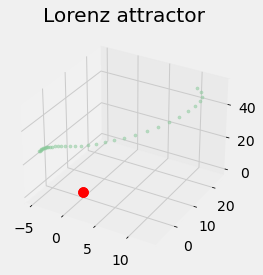

In [10]:
train_model(training_results[3])

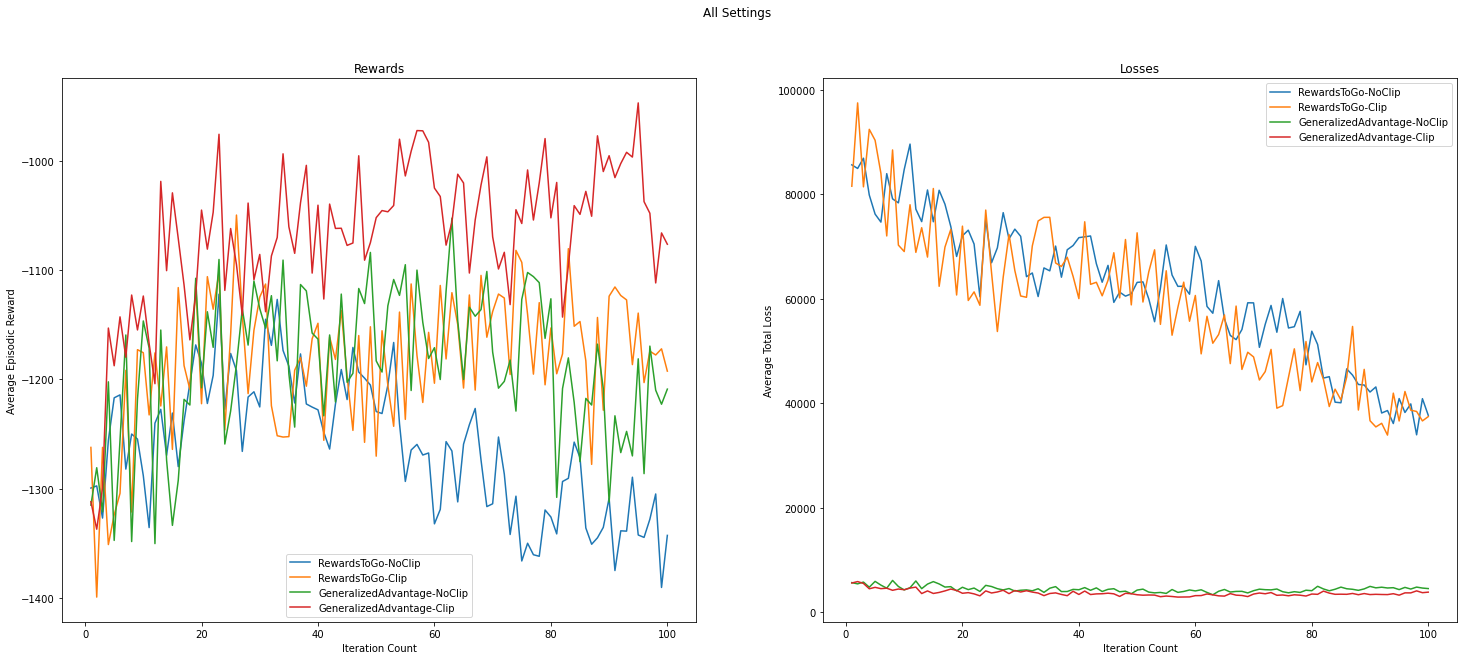

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 10))

fig.suptitle("All Settings")
x = training_results[0].results["iteration_count"]

ax1.set_title("Rewards")
ax1.set_xlabel("Iteration Count")
ax1.set_ylabel("Average Episodic Reward")

ax2.set_title("Losses")
ax2.set_xlabel("Iteration Count")
ax2.set_ylabel("Average Total Loss")

for training_result in training_results:
    ax1.plot(x, training_result.results["accumulated_rewards"], label=training_result.label)
    ax2.plot(x, training_result.results["total_losses"], label=training_result.label)

ax1.legend()
ax2.legend()
plt.show()